# RAIN IN AUSTRALIA Model part

*Authors: Petrillo Daniele, Zampella Maria*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # for splitting the dataset
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier

from sklearn.feature_selection import VarianceThreshold,SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression, Perceptron

from sklearn.model_selection import GridSearchCV, StratifiedKFold , KFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score,confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
import warnings
warnings.filterwarnings("ignore")

First we define a function for plotting the learning curves.

In [ ]:
# We define a function which draws the learning curve.
def learning_curves(estimator,X_train_std,y_train):
  train_sizes, train_scores , test_scores = learning_curve (estimator=estimator , X=X_train_std, y=y_train, train_sizes =np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1,scoring='precision')

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std( train_scores , axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std( test_scores , axis=1)

  #Now let's plot the learning curve function

  #plot the results for the train
  plt.plot( train_sizes , train_mean, color='blue', marker='o', markersize=5, label='Training precision' )
  #plot also the region in which varies the accuracy
  plt.fill_between ( train_sizes , train_mean + train_std , train_mean - train_std , alpha=0.15, color='blue')

  #plot the results as previous but for the test
  plt.plot( train_sizes , test_mean, color='green', linestyle ='--', marker='s', markersize=5, label='Validation precision' )
  plt.fill_between ( train_sizes , test_mean + test_std , test_mean - test_std , alpha=0.15, color='green')

  plt.grid()
  plt.xlabel('Number of training examples')
  plt.ylabel('Precision')
  plt.legend(loc='lower right' )
  plt.show()

## **Datasets**



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# First, we create a file in which we write the scores obtain for each model, each time that we run the code with a different dataset.

results = open("gdrive/MyDrive/mlxp/model_results_randomfor.txt", "w")


First, we load the datasets that we have previously build.

In [ ]:
dataset = pd.read_csv("gdrive/MyDrive/mlxp/weatherAUS.csv") #original dataset
df_num = pd.read_csv("gdrive/MyDrive/mlxp/df_num.csv") #dataset which contains only the numerical columns
df_num_rolling = pd.read_csv("gdrive/MyDrive/mlxp/df_num_rolling.csv") #dataset which contains the numerical columns and the rolling mean of that columns
df_filled = pd.read_csv("gdrive/MyDrive/mlxp/df_filled.csv") #dataset which contains data,location, all the numerical columns and all the categorical columns
location_dummy = pd.read_csv("gdrive/MyDrive/mlxp/location_dummy.csv") #dataset which contains the dummy variable for the location column
wind_dummy = pd.read_csv("gdrive/MyDrive/mlxp/wind_dummy.csv") #dataset which contains the dummy variable for the 3 categorical columns referred to wind
month_dummy = pd.read_csv("gdrive/MyDrive/mlxp/month_dummy.csv") #dataset which contains the dummy variable for the month (obtained from the date column)
df_binaries = pd.read_csv("gdrive/MyDrive/mlxp/df_binaries.csv") #dataset which contains the column RainToday and RainTomorrow encoded with 0 and 1.


In [ ]:
X_train_pca = np.loadtxt("gdrive/MyDrive/mlxp/pca/x_train_pca.txt") 
X_test_pca = np.loadtxt("gdrive/MyDrive/mlxp/pca/x_test_pca.txt") 
X_train_lda = np.loadtxt("gdrive/MyDrive/mlxp/pca/x_train_lda.txt") 
X_test_lda = np.loadtxt("gdrive/MyDrive/mlxp/pca/x_test_lda.txt")
y_train_pca = np.loadtxt("gdrive/MyDrive/mlxp/pca/y_train_pca.txt") 
y_test_pca = np.loadtxt("gdrive/MyDrive/mlxp/pca/y_test_pca.txt") 


Then, we create the dataset we want to use for our analysis by composing the piece of dataset that we want

In [ ]:
df = pd.concat([df_num_rolling,df_binaries], axis = 1)
df.columns
results.write('The dataset used contains: df_num_rolling,df_binaries \n')

55

Successively, we split the dataset into train and test and then we standardize it.

In [ ]:
X = df.drop(['RainTomorrow'],axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1,stratify=y) #80% train, 20%test


In [ ]:
stdsc=StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


In [ ]:
#per lda
# X_train_std = X_train_pca
# X_test_std=X_test_pca
# y_train = y_train_pca
# y_test = y_test_pca

## **Statistical Model**

### **Perceptron**

The first model we apply is the Perceptron. As score we use the recall because our dataset is unbalanced so using the classical accuracy socre could return a not reliable result.

In [ ]:
# We apply GridSearch for finding the best combination of parameter.
param_grid = [{'eta0': [0.01, 0.1, 0.5, 1], 'penalty':['l1','l2']}]

gs_ppn = GridSearchCV(estimator=Perceptron(), param_grid=param_grid, scoring='precision', cv=10, refit =True, n_jobs=-1)
gs_ppn = gs_ppn.fit(X_train_std, y_train )
ppn = gs_ppn.best_estimator_

print(gs_ppn.best_score_)
print(gs_ppn.best_params_)

results.write('PERCEPTRON \n best_parameter: '+ str(gs_ppn.best_params_)+ '\n')

0.6126833252992061
{'eta0': 0.5, 'penalty': 'l1'}


60

In [ ]:
skf = StratifiedKFold( n_splits =10)
kfold = skf.get_n_splits(X_train_std, y_train)

scores = cross_val_score(estimator=ppn, X=X_train_std, y=y_train, cv=10, n_jobs=1, scoring='precision')

print('Perceptron precision: %.3f +/- %.3f' % (np.mean(scores), np.std( scores )))

results.write('train precision: %.3f +/- %.3f' % (np.mean(scores), np.std( scores )) +'\n' )

Perceptron precision: 0.613 +/- 0.142


33

In [ ]:
#Now that we have found the best combination of parameter we can apply the best model to fit the test dataset

y_pred_ppn = ppn.predict(X_test_std)

print('Test precision: %.3f' % precision_score (y_test, y_pred_ppn ))
print('Misclassified samples: %d' %(y_test != y_pred_ppn).sum())

results.write('test precision: %.3f' % precision_score (y_test, y_pred_ppn ) + '\n')
results.write('Misclassified samples: %d' %(y_test != y_pred_ppn).sum() + '\n')

Test precision: 0.602
Misclassified samples: 4608


28

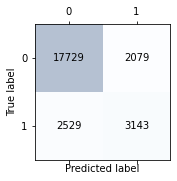

In [ ]:
#confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ppn)

#Now let's plot it
fig, ax = plt.subplots ( figsize =(2.5, 2.5) )
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]) :
    for j in range(confmat.shape[1]) :
        ax.text (x=j, y=i, s=confmat[i, j ], va='center' , ha='center')
plt.xlabel('Predicted label' )
plt.ylabel('True label' )
plt.show()

In [ ]:
precision_ppn =precision_score (y_true=y_test, y_pred=y_pred_ppn)
recall_ppn =recall_score (y_true=y_test, y_pred=y_pred_ppn)
f1_ppn =  f1_score(y_true=y_test, y_pred=y_pred_ppn)
accuracy_ppn = accuracy_score(y_true=y_test, y_pred=y_pred_ppn)

print('Precision: %.3f' % precision_ppn)
print('Recall: %.3f' % recall_ppn)
print('F1: %.3f' % f1_ppn)
print('Accuracy: %.3f' % accuracy_ppn)

results.write('test Precision: %.3f' % precision_ppn + '\n' + 'test Recall: %.3f' % recall_ppn +'\n'+ 'test F1: %.3f' % f1_ppn + '\n' + 'test Accuracy: %.3f' % accuracy_ppn + '\n' )

Precision: 0.602
Recall: 0.554
F1: 0.577
Accuracy: 0.819


77

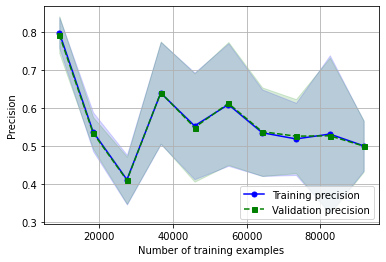

In [ ]:
learning_curves(ppn,X_train_std,y_train)

For the following model we apply the same procedure applied for the Perceptron.

### **Logistic Regression**

In [ ]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range, 'solver' : [ 'newton-cg','sag','saga' ]}] # ‘sag’ and ‘saga’ are faster for larger dataset- 
                        #newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories.

gs_lr = GridSearchCV(estimator=LogisticRegression(penalty='l2'), param_grid=param_grid, scoring="precision", cv=10, refit =True, n_jobs=-1)
gs_lr = gs_lr.fit(X_train_std, y_train)
lr = gs_lr.best_estimator_

print(gs_lr.best_score_)
print(gs_lr.best_params_)

results.write('LOGISTIC REGRESSION \n best_parameter: '+ str(gs_lr.best_params_)+ '\n')

0.749832610250975
{'C': 0.001, 'solver': 'newton-cg'}


74

In [ ]:
scores = cross_val_score(estimator=lr, X=X_train_std, y=y_train, cv=10, n_jobs=1, scoring='precision')

print('Logistic Regression precision: %.3f +/- %.3f' % (np.mean(scores), np.std( scores )))
results.write('train precision: %.3f +/- %.3f' % (np.mean(scores), np.std( scores )) +'\n' )

Logistic Regression precision: 0.750 +/- 0.013


33

In [ ]:
#Now that we have found the best combination of parameter we can apply the best model to fit the test dataset

y_pred_lr = lr.predict(X_test_std)

print('Test precision: %.3f' % precision_score (y_test, y_pred_lr ))
print('Misclassified samples: %d' %(y_test != y_pred_lr).sum())

results.write('test precision: %.3f' % precision_score (y_test, y_pred_lr ) + '\n')
results.write('Misclassified samples: %d' %(y_test != y_pred_lr).sum() + '\n')

Test precision: 0.743
Misclassified samples: 3897


28

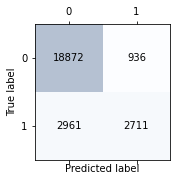

In [ ]:
#confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_lr)

#Now let's plot it
fig, ax = plt.subplots ( figsize =(2.5, 2.5) )
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]) :
    for j in range(confmat.shape[1]) :
        ax.text (x=j, y=i, s=confmat[i, j ], va='center' , ha='center')
plt.xlabel('Predicted label' )
plt.ylabel('True label' )
plt.show()

In [ ]:
precision_lr =precision_score (y_true=y_test, y_pred=y_pred_lr)
recall_lr =recall_score (y_true=y_test, y_pred=y_pred_lr)
f1_lr =  f1_score(y_true=y_test, y_pred=y_pred_lr)
accuracy_lr = accuracy_score(y_true=y_test, y_pred=y_pred_lr)

print('Precision: %.3f' % precision_lr)
print('Recall: %.3f' % recall_lr)
print('F1: %.3f' % f1_lr)
print('Accuracy: %.3f' % accuracy_lr)

results.write('test Precision: %.3f' % precision_lr + '\n' + 'test Recall: %.3f' % recall_lr +'\n'+ 'test F1: %.3f' % f1_lr + '\n' + 'test Accuracy: %.3f' % accuracy_lr + '\n' )

Precision: 0.743
Recall: 0.478
F1: 0.582
Accuracy: 0.847


77

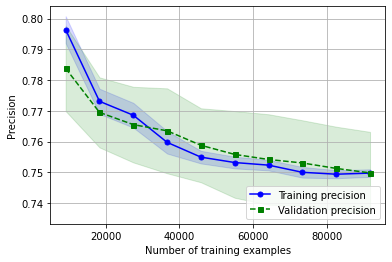

In [ ]:
learning_curves(lr,X_train_std,y_train)

### **Random Forest**

In [ ]:
# We apply GridSearch for finding the best combination of parameter.
param_grid = [{'n_estimators': [10,50,100], 'max_depth':[10,100,200], 'criterion' : [ 'gini' ]},
              {'n_estimators': [10,50,100], 'max_depth':[10,100,200], 'criterion':['entropy']}]

gs_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='precision', cv=10, refit =True, n_jobs=-1)
gs_rf = gs_rf.fit(X_train_std, y_train)
rf = gs_rf.best_estimator_

print(gs_rf.best_score_)
print(gs_rf.best_params_)

results.write('RANDOM FOREST \n best_parameter: '+ str(gs_rf.best_params_)+ '\n')

0.7793354682105113
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}


95

In [ ]:
scores = cross_val_score(estimator=rf, X=X_train_std, y=y_train, cv=10, n_jobs=-1, scoring='precision')

print('Random Forest recall: %.3f +/- %.3f' % (np.mean(scores), np.std( scores )))
results.write('train precision: %.3f +/- %.3f' % (np.mean(scores), np.std( scores )) +'\n' )

Random Forest recall: 0.780 +/- 0.012


33

In [ ]:
#Now that we have found the best combination of parameter we can apply the best model to fit the test dataset
y_pred_rf = rf.predict(X_test_std)

print('Test precision: %.3f' % precision_score (y_test, y_pred_rf ))
print('Misclassified samples: %d' %(y_test != y_pred_rf).sum())

results.write('test precision: %.3f' % precision_score (y_test, y_pred_rf ) + '\n')
results.write('Misclassified samples: %d' %(y_test != y_pred_rf).sum() + '\n')

Test precision: 0.771
Misclassified samples: 3803


28

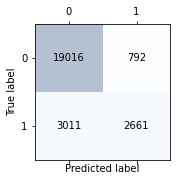

In [ ]:
#confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

#Now let's plot it
fig, ax = plt.subplots ( figsize =(2.5, 2.5) )
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]) :
    for j in range(confmat.shape[1]) :
        ax.text (x=j, y=i, s=confmat[i, j ], va='center' , ha='center')
plt.xlabel('Predicted label' )
plt.ylabel('True label' )
plt.show()

In [ ]:
precision_rf =precision_score (y_true=y_test, y_pred=y_pred_rf)
recall_rf =recall_score (y_true=y_test, y_pred=y_pred_rf)
f1_rf =  f1_score(y_true=y_test, y_pred=y_pred_rf)
accuracy_rf = accuracy_score(y_true=y_test, y_pred=y_pred_rf)

print('Precision: %.3f' % precision_rf)
print('Recall: %.3f' % recall_rf)
print('F1: %.3f' % f1_rf)
print('Accuracy: %.3f' % accuracy_rf)

results.write('test Precision: %.3f' % precision_rf + '\n' + 'test Recall: %.3f' % recall_rf +'\n'+ 'test F1: %.3f' % f1_rf + '\n' + 'test Accuracy: %.3f' % accuracy_rf + '\n')

Precision: 0.771
Recall: 0.469
F1: 0.583
Accuracy: 0.851


77

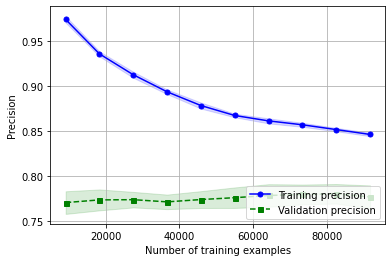

In [ ]:
learning_curves(rf,X_train_std,y_train)

### **Neural Network**

Eventually, we decide to apply a simple Neural Network

In [ ]:
from keras.layers.regularization.spatial_dropout3d import Dropout
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 64,  activation = 'relu', input_dim = X_train_std.shape[1]))
model.add(Dense(units = 128,  activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64,  activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 32,  activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.Precision()])
# Fit the model
history = model.fit(X_train_std, y_train, epochs=50, batch_size=32, 
                     validation_split=0.2,
                    verbose=1)
#Use the model to predict the label of the test dataset
y_pred_nn = model.predict(X_test_std)>0.5

# evaluate the model
scores = model.evaluate(X_test_std, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

results.write("NEURAL NETWORK \n Precision: " + str( scores[1]*100) + '\n')

Epoch 1/50
2548/2548 [==============================] - 13s 4ms/step - loss: 0.3823 - precision: 0.7150 - val_loss: 0.3484 - val_precision: 0.7507
Epoch 2/50
2548/2548 [==============================] - 10s 4ms/step - loss: 0.3611 - precision: 0.7457 - val_loss: 0.3477 - val_precision: 0.7405
Epoch 3/50
2548/2548 [==============================] - 10s 4ms/step - loss: 0.3560 - precision: 0.7532 - val_loss: 0.3440 - val_precision: 0.7496
Epoch 4/50
2548/2548 [==============================] - 10s 4ms/step - loss: 0.3530 - precision: 0.7534 - val_loss: 0.3417 - val_precision: 0.7782
Epoch 5/50
2548/2548 [==============================] - 10s 4ms/step - loss: 0.3511 - precision: 0.7568 - val_loss: 0.3407 - val_precision: 0.7596
Epoch 6/50
2548/2548 [==============================] - 10s 4ms/step - loss: 0.3497 - precision: 0.7605 - val_loss: 0.3426 - val_precision: 0.8165
Epoch 7/50
2548/2548 [==============================] - 10s 4ms/step - loss: 0.3478 - precision: 0.7628 - val_loss: 0.

46

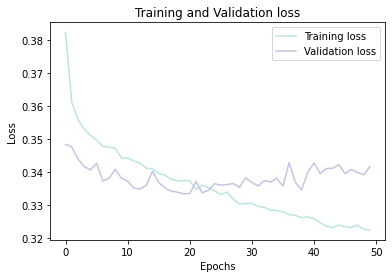

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

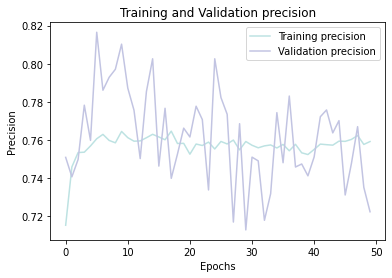

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['precision']], "#BDE2E2", label='Training precision')
plt.plot(history_df.loc[:, ['val_precision']], "#C2C4E2", label='Validation precision')

plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

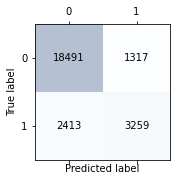

In [ ]:
#confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_nn)

#Now let's plot it
fig, ax = plt.subplots ( figsize =(2.5, 2.5) )
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]) :
    for j in range(confmat.shape[1]) :
        ax.text (x=j, y=i, s=confmat[i, j ], va='center' , ha='center')
plt.xlabel('Predicted label' )
plt.ylabel('True label' )
plt.show()

In [ ]:
misclassified=0
for idx,el in (enumerate(y_test)):
  if el != int(y_pred_nn[idx]):
    misclassified += 1
misclassified


3730

In [ ]:
precision_nn =precision_score (y_true=y_test, y_pred=y_pred_nn)
recall_nn =recall_score (y_true=y_test, y_pred=y_pred_nn)
f1_nn =  f1_score(y_true=y_test, y_pred=y_pred_nn)
accuracy_nn = accuracy_score(y_true=y_test, y_pred=y_pred_nn)

misclassified=0
for idx,el in (enumerate(y_test)):
  if el != int(y_pred_nn[idx]):
    misclassified += 1

print('Misclassified samples: %d' %misclassified)
print('Precision: %.3f' % precision_nn)
print('Recall: %.3f' % recall_nn)
print('F1: %.3f' % f1_nn)
print('Accuracy: %.3f' % accuracy_nn)

results.write('Misclassified samples: %d' %misclassified+'\n'+'test Precision: %.3f' % precision_nn + '\n' + 'test Recall: %.3f' % recall_nn +'\n'+ 'test F1: %.3f' % f1_nn + '\n' + 'test Accuracy: %.3f' % accuracy_nn + '\n')

Misclassified samples: 3730
Precision: 0.712
Recall: 0.575
F1: 0.636
Accuracy: 0.854


105

In [ ]:
clf_labels = ['Perceptron' , 'Logistic Regression' , 'Random Forest']

print('5-fold cross validation :\n')
for clf, label in zip ([ppn,lr,rf], clf_labels ):
    scores = cross_val_score ( estimator=clf, X=X_train_std, y=y_train, cv=5, scoring='roc_auc')
    print ('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std() , label ))

5-fold cross validation :

ROC AUC: 0.79 (+/- 0.04) [Perceptron]
ROC AUC: 0.86 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.00) [Random Forest]


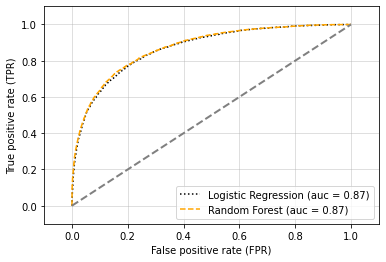

In [ ]:
#In the end we compare the methood with the ROC AUC curve
all_clf = [lr,rf]
colors = ['black', 'orange'   ]
linestyles = [':' , '--']
clf_labels = ['Logistic Regression' , 'Random Forest']

for clf, label , clr , ls in zip( all_clf , clf_labels , colors , linestyles ):
    # assuming the label of the positive class is 1
    y_pred = clf.fit ( X_train , y_train ).predict_proba (X_test) [:, 1]
    fpr , tpr , thresholds = roc_curve( y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot ( fpr , tpr , color=clr, linestyle =ls, label ='%s (auc = %0.2f)' %(label, roc_auc))
plt.legend(loc='lower right' )
plt.plot([0, 1], [0, 1], linestyle ='--', color='gray', linewidth =2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()


In [ ]:
results.close()